<a href="https://colab.research.google.com/github/DivyaMeenaSundaram/Deep_Learning_Lab/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import torch

# 📌 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📌 Define Dataset Class
class ChestXrayDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")  # grayscale
        if self.transform:
            image = self.transform(image)
        return image

# 📌 Define Transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# 📌 Collect all image paths from the Drive folder
data_dir = "/content/drive/MyDrive/Pneumonia dataset"
image_extensions = ['*.jpg', '*.jpeg', '*.png']
image_paths = []

for ext in image_extensions:
    image_paths.extend(glob.glob(os.path.join(data_dir, '**', ext), recursive=True))

print(f"Total images found: {len(image_paths)}")

# 📌 Load Dataset and DataLoader
dataset = ChestXrayDataset(image_paths, transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# ✅ Test a Batch
for batch in dataloader:
    print(batch.shape)  # Should print: torch.Size([2, 1, 64, 64])
    break


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images found: 4270
torch.Size([2, 1, 64, 64])


In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 32, 4, 2, 1, bias=False), # Output 32 channels for the next layer
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, img_channels, 4, 2, 1, bias=False), # New layer to upsample to 64x64
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, 32, 4, 2, 1, bias=False),   # (32, 32, 32)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),             # (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),            # (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, 4, 2, 0, bias=False),             # (1, 1, 1)
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [10]:
z_dim = 100
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))


Epoch 0 | D Loss: 0.2896 | G Loss: 3.6720


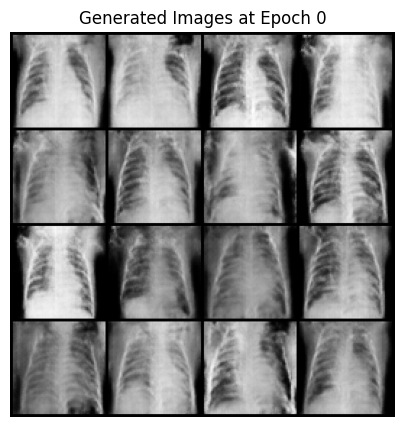

Epoch 2 | D Loss: 0.2973 | G Loss: 4.5987


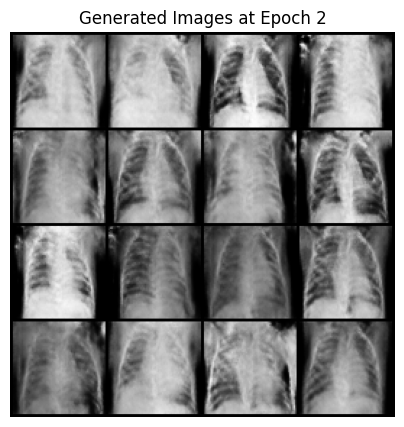

In [12]:
fixed_noise = torch.randn(16, z_dim, 1, 1).to(device)
epochs = 3

for epoch in range(epochs):
    for real_imgs in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # === Train Discriminator ===
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_imgs = G(noise)

        D_real = D(real_imgs).view(-1)
        D_fake = D(fake_imgs.detach()).view(-1)

        real_labels = torch.ones_like(D_real).to(device)
        fake_labels = torch.zeros_like(D_fake).to(device)

        D_loss_real = criterion(D_real, real_labels)
        D_loss_fake = criterion(D_fake, fake_labels)
        D_loss = D_loss_real + D_loss_fake

        opt_D.zero_grad()
        D_loss.backward()
        opt_D.step()

        # === Train Generator ===
        output = D(fake_imgs).view(-1)
        G_loss = criterion(output, torch.ones_like(output).to(device))

        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()

    # === Display progress ===
    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch} | D Loss: {D_loss.item():.4f} | G Loss: {G_loss.item():.4f}")
        with torch.no_grad():
            fake = G(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake, nrow=4, normalize=True)
        plt.figure(figsize=(5,5))
        plt.imshow(np.transpose(grid, (1, 2, 0)), cmap='gray')
        plt.title(f"Generated Images at Epoch {epoch}")
        plt.axis('off')
        plt.show()
